### Import libraries

In [96]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight, shuffle
import warnings
import logging

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

print(tf.config.list_physical_devices())

import shutil
from IPython.display import FileLink


2.10.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Set seed for reproducibility

In [97]:
# Random seed for reproducibility
seed = 100

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

Hyper parameters for augmentation, splines interpolation and scaling

In [98]:
scaling = True # applies standard scaling to the data
apply_augmentation = True # introduces white noise to the oversampled data
use_splines = True # uses splines for cubic interpolation the data

 # Load the training dataset

In [99]:
path = os.getcwd()
# Load the .npy file
X = np.load(path+r'\training\x_train.npy')
y = np.load(path+r'\training\y_train.npy')

# Convert to float32 for less precision and better performance
X = X.astype(np.float32)
y = y.astype(np.int32)

print(X.shape, X.dtype, sep=", ")   
print(y.shape, y.dtype, sep=", ") 

(2429, 36, 6), float32
(2429,), int32


Plotting the classes distributions

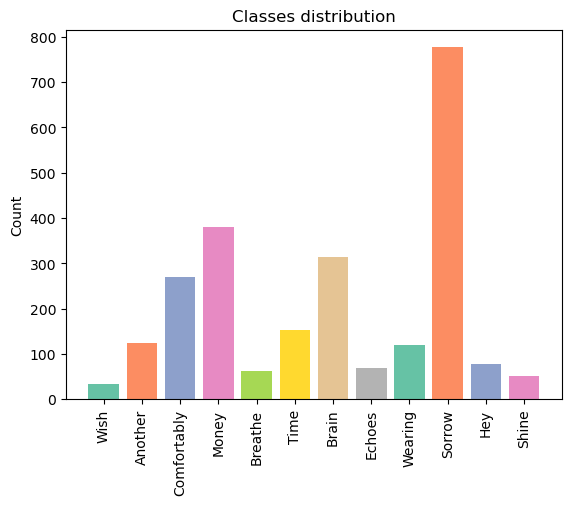

In [100]:
# Map classes STRINGS to integers
label_mapping = {
    'Wish': 0,
    'Another': 1,
    'Comfortably': 2,
    'Money': 3,
    'Breathe': 4,
    'Time': 5,
    'Brain': 6,
    'Echoes': 7,
    'Wearing': 8,
    'Sorrow': 9,
    'Hey': 10,
    'Shine': 11,  
}

#vertical bar plot of the classes distribution in y
plt.title('Classes distribution')
plt.bar(label_mapping.keys(), np.bincount(y), color = matplotlib.colormaps['Set2'].colors)
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.show()


Class weights computation

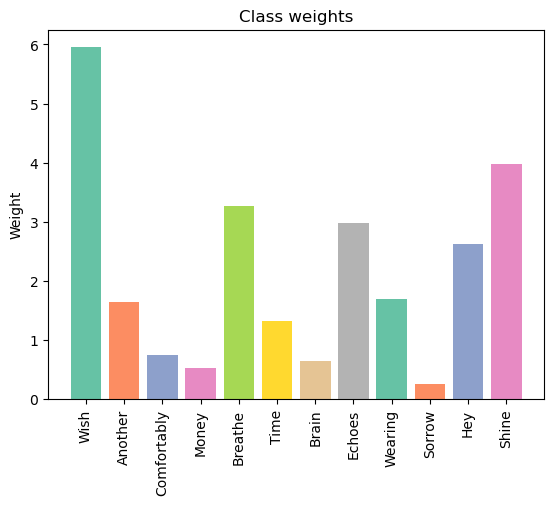

In [101]:
# Compute the class weights in order to balance loss during training
labels = np.unique(np.fromiter([t for t in y], np.int32))
class_weights = dict(enumerate(class_weight.compute_class_weight('balanced', classes=labels, y=y)))

# plot class weights with respect to the labels
plt.title('Class weights')
plt.bar(label_mapping.keys(), class_weights.values(), color = matplotlib.colormaps['Set2'].colors)
plt.xticks(rotation=90)
plt.ylabel('Weight')
plt.show()


### Data preprocessing with cubic interpolation between data points for increasing resolution

Before the cubic spline interpolation 

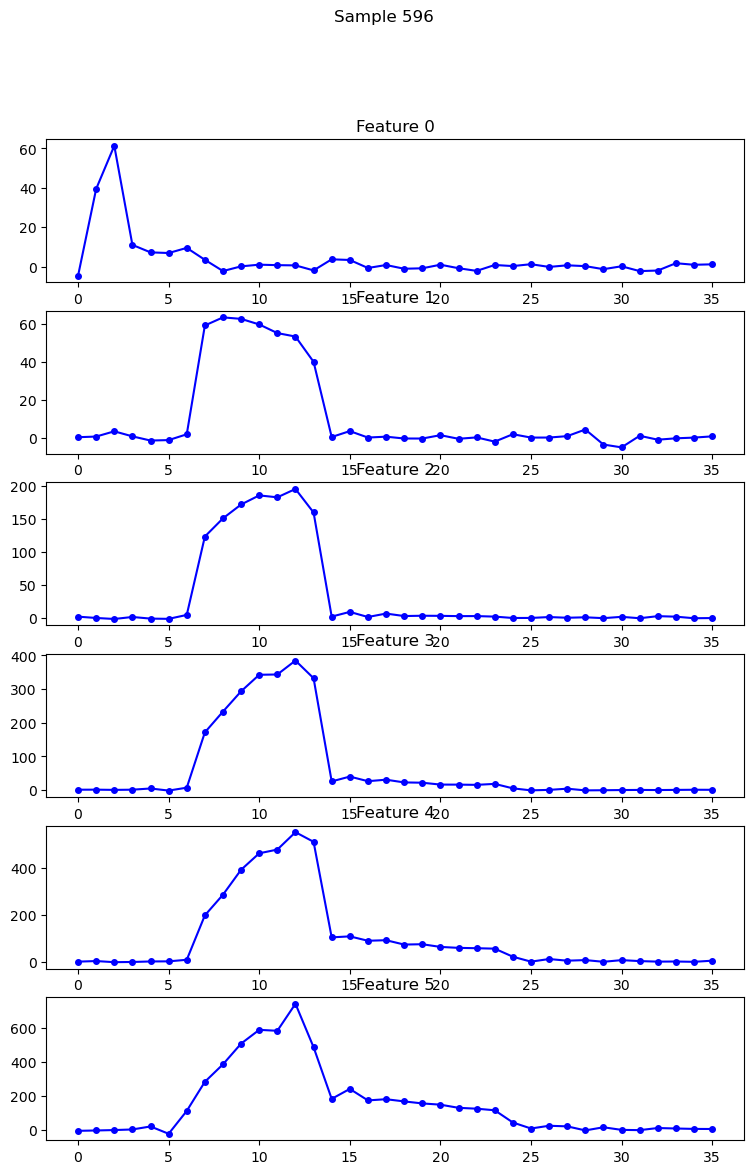

In [102]:
# plot the sequence of points in a randomly drawn sample from X
sample = random.randint(0, X.shape[0])

# create a figure with 6 subplots, one plot per each feature
fig, axs = plt.subplots(6, 1, figsize=(9, 13))
fig.suptitle('Sample ' + str(sample))
for i in range(6):
	axs[i].set_title('Feature ' + str(i))
	# add a dot at each point in the sequence
	axs[i].plot(X[sample, :, i], 'o-', color='blue', markersize=4)

plt.show()


Application of spline interpolation to create a spline with new points

In [103]:
# add cubic spline interpolation between the data points of the sequence X[sample, :, i] and return the new set of points

from scipy import interpolate

interpolation_multiplier = 3 # resolution multiplier

# triple the number of points in the sequence to increase the resolution by a factor of 3
x_lin = np.linspace(0, 35, 36 * interpolation_multiplier)

# new augmented dataset
X_spline = np.zeros((X.shape[0], x_lin.size, 6))
print(X_spline.shape)

for i in np.arange(X[:, 0, 0].size): # for each sample
	for j in np.arange(6): # for each feature
		# add a cubic spline interpolation between the data points of X[sample, :, 0]
		interpolation = interpolate.interp1d(np.arange(0, 36), X[i, :, j], kind='cubic', fill_value="extrapolate")
		X_spline[i, :, j] = interpolation(x_lin)


(2429, 108, 6)


Plot the new sequence of interpolated points

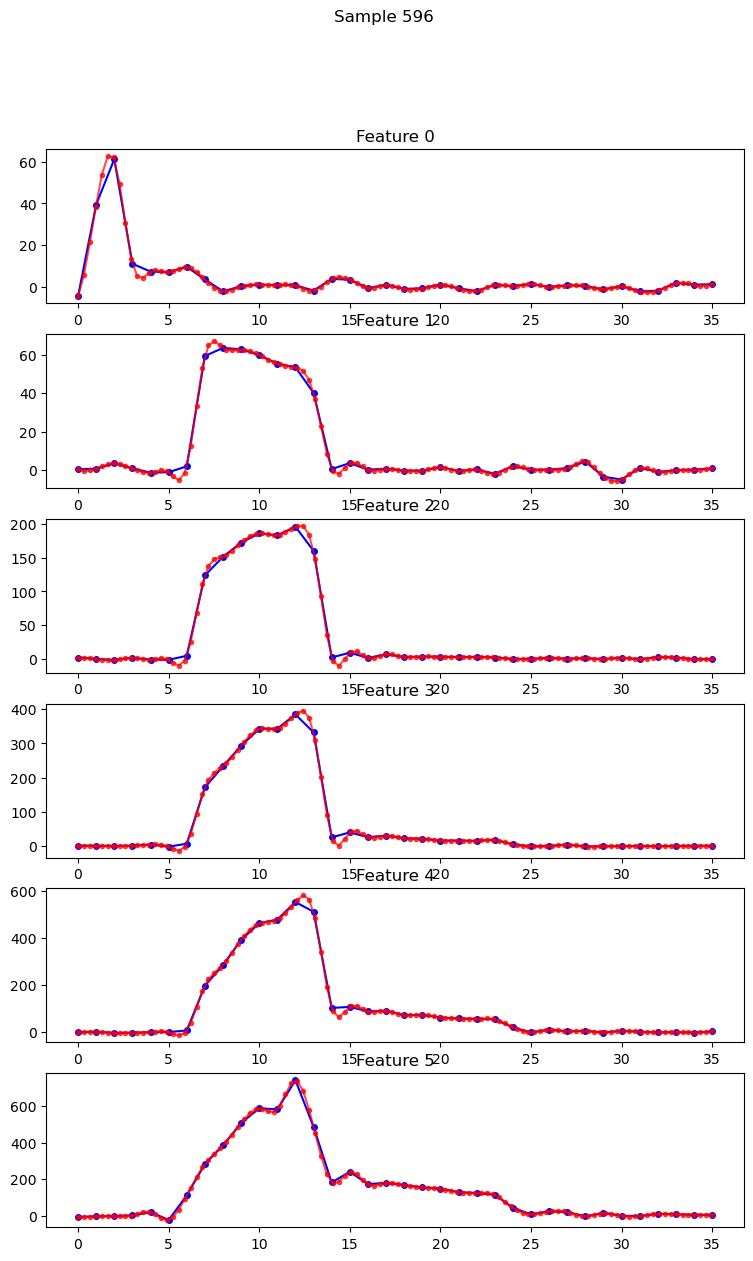

In [104]:
# create a figure with 6 subplots, one plot per each feature
fig, axs = plt.subplots(6, 1, figsize=(9, 14))
fig.suptitle('Sample ' + str(sample))
for i in range(6):
	axs[i].set_title('Feature ' + str(i))
	# plots the given sequence of points without interpolation
	axs[i].plot(np.arange(0, 36), X[sample, :, i], 'o-', color='blue', markersize=4)

	# plots the new set of points with cubic spline interpolation
	axs[i].plot(x_lin, X_spline[sample, :, i], "o-", color='red', markersize = 3, alpha = 0.7)

plt.show()

Applies splines interpolation to the dataset

In [105]:

# when using splines, it's better to have a bigger filter size in the convolutional layers
filter_multiplier = 1
if (use_splines):
    filter_multiplier = 3
    X = X_spline


### Offline data augmentation with oversampling 

Training - Validation split

In [106]:

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
print("training set : ", X_train.shape)
print("test set: ", X_test.shape)

training set :  (1943, 108, 6)
test set:  (486, 108, 6)


Oversampling the classes in a manner proportional to the class weights

In [107]:
# for each class take the samples and copy them in a new array
X_augmented = np.empty((0, X_train.shape[1], X_train.shape[2]), dtype=np.float32)
y_augmented = np.empty((0,), dtype=np.int32)

# compute the increment multiplier for each class based on its class weight
increment = np.zeros(len(label_mapping), dtype=np.int32)
for i in range(len(label_mapping)):
	increment[i] = int(np.ceil(np.max(np.bincount(y)) / np.bincount(y)[i]))

print("increment multiplier = ", increment)

# for each sample in the original dataset, copy it in the new array as many times as its class increment multiplier
for i in range(len(y_train)):

	# each sample is copied increment[y[i]] times in the new array
	for j in range(increment[y_train[i]]):
		X_augmented = np.append(X_augmented, np.expand_dims(X_train[i], axis=0), axis=0)
		y_augmented = np.append(y_augmented, np.expand_dims(y_train[i], axis=0), axis=0)

		# compute min and max for each X[i, :, k]
		for k in range(X.shape[2]):
			mins = np.min(X_train[i, :, k], axis=0)
			maxs = np.max(X_train[i, :, k], axis=0)

			# then add random gaussian noise to each sample
			values = np.random.normal(0, 0.05 * (maxs - mins), X_train.shape[1])
			X_augmented[i, :, k] = np.add(X_augmented[i, :, k], values)


print("new augmented dataset size ", X_augmented.shape, y_augmented.shape, sep=", ")

# shuffle the data
X_augmented, y_augmented = shuffle(X_augmented, y_augmented, random_state=seed)


increment multiplier =  [23  7  3  3 13  6  3 12  7  1 11 16]
new augmented dataset size , (8282, 108, 6), (8282,)


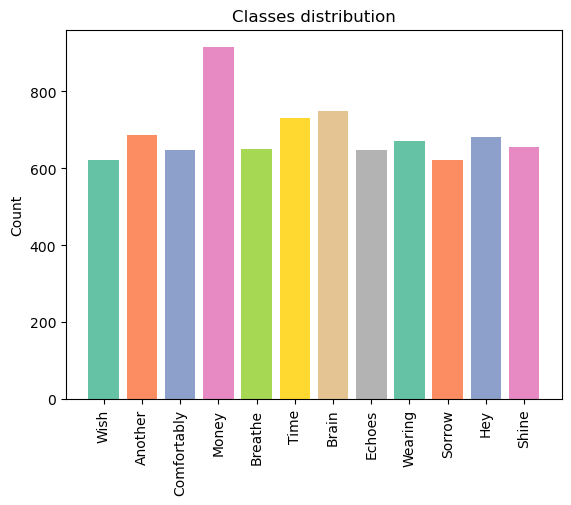

In [108]:

# plot the new distribution of the classes
plt.title('Classes distribution')
plt.bar(label_mapping.keys(), np.bincount(y_augmented), color = matplotlib.colormaps['Set2'].colors)
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.show()


New class weights after the augmentation

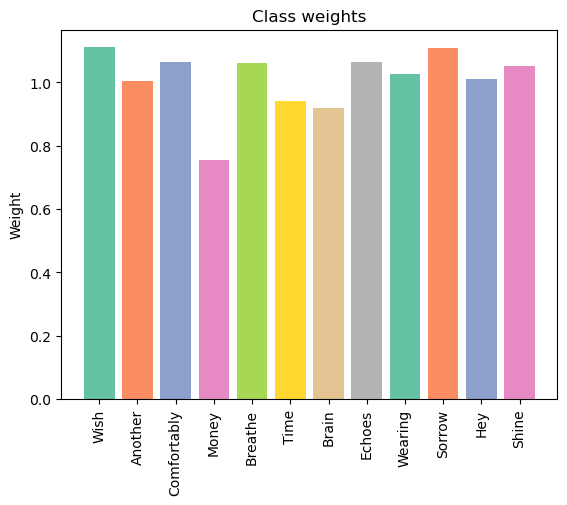

In [109]:
# compute and plot the new class weights
labels = np.unique(np.fromiter([t for t in y_augmented], np.int32))
class_weights = dict(enumerate(class_weight.compute_class_weight('balanced', classes=labels, y=y_augmented)))

plt.title('Class weights')
plt.bar(label_mapping.keys(), class_weights.values(), color = matplotlib.colormaps['Set2'].colors)
plt.xticks(rotation=90)
plt.ylabel('Weight')
plt.show()


Save the augmented dataset

In [110]:
if (apply_augmentation):
	# save augmented dataset in the same dataset
	X_train = X_augmented
	y_train = y_augmented


### Application of Standard Scaler to the dataset

In [111]:
features_num = X_train.shape[2]
print("features: ", features_num)

from sklearn.preprocessing import StandardScaler

if (scaling):
    scaler_std = StandardScaler()

    num_instances, num_time_steps, num_features = X_train.shape
    X_train = np.reshape(X_train, newshape=(-1, num_features))
    X_train = scaler_std.fit_transform(X_train)

    X_train = np.reshape(X_train, newshape=(num_instances, num_time_steps, num_features))

    num_instances, num_time_steps, num_features = X_test.shape
    X_test = np.reshape(X_test, newshape=(-1, num_features))
    X_test = scaler_std.transform(X_test)

    X_test = np.reshape(X_test, newshape=(num_instances, num_time_steps, num_features))


features:  6


Categorical labels for the training and test data

In [112]:
# Convert the sparse labels to categorical values
y_train = tfk.utils.to_categorical(y_train)
y_test = tfk.utils.to_categorical(y_test)
print(X_train.shape, y_train.shape, sep=", ")
print(X_test.shape, y_test.shape, sep=", ")

(8282, 108, 6), (8282, 12)
(486, 108, 6), (486, 12)


## Build the models

Hyperparameters

In [113]:
input_shape = X_train.shape[1:]
print("input shape: ", input_shape)
classes = y_train.shape[-1]
batch_size = 128
epochs = 800


input shape:  (108, 6)


Plot history of the training and the learning rate schedule

In [114]:
def plot_history(history):
	best_epoch = np.argmax(history['val_accuracy'])
	plt.figure(figsize=(17,4))
	plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
	plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
	plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
	plt.title('Categorical Crossentropy')
	plt.legend()
	plt.grid(alpha=.3)
	plt.show()

	plt.figure(figsize=(17,4))
	plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
	plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
	plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
	plt.title('Accuracy')
	plt.legend()
	plt.grid(alpha=.3)
	plt.show()

	plt.figure(figsize=(17,4))
	plt.title('Learning Rate Schedule')
	plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
	plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
	plt.legend()
	plt.grid(alpha=.3)
	plt.show()

Plot confusion matrix, F1 scores and displays model accuracy

In [115]:
def plot_statistics(predictions):	
	# Compute the confusion matrix
	cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

	# Compute the classification metrics
	accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
	precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
	recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
	f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
	print('Accuracy:',accuracy.round(4))
	print('Precision:',precision.round(4))
	print('Recall:',recall.round(4))
	print('F1:',f1.round(4))

	# Plot the confusion matrix
	plt.figure(figsize=(7, 6))
	plt.title('Confusion matrix')
	sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()), annot=True, fmt="d")
	plt.xlabel('True labels')
	plt.ylabel('Predicted labels')
	plt.show()

	# horizontal bar plot of the f1 scores for each class
	plt.figure(figsize=(6,4))
	plt.grid(alpha=.3)
	plt.barh(y=list(label_mapping.keys()), width=f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average=None))
	plt.title('F1 scores')
	plt.show()

#### Only convolutional and dense layers

In [116]:
def build_conv_dense(input_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    x = tfkl.Conv1D(
        filters = 128,
        kernel_size = 3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
        )(input_layer)
    
    x = tfkl.MaxPooling1D()(x)

    x = tfkl.Conv1D(
        filters = 256,
        kernel_size = 3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
        )(x)
    
    x = tfkl.MaxPooling1D(name='mp2')(x)

    x = tfkl.Conv1D(
        filters = 256,
        kernel_size = 3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
        )(x)
    
    x = tfkl.GlobalAveragePooling1D()(x)
    
    x = tfkl.Dense(
        units = 256,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
        )(x)

    x = tfkl.Dense(
        units = 256,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
        )(x)
    
    x = tfkl.Dropout(0.4, seed=seed)(x)

    output_layer = tfkl.Dense(classes, activation='softmax')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model1')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(5e-4), metrics='accuracy')

    # Return the model
    return model


In [117]:
model = build_conv_dense(input_shape)
model.summary()

Model: "model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 108, 6)]          0         
                                                                 
 conv1d_21 (Conv1D)          (None, 108, 128)          2432      
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 54, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_22 (Conv1D)          (None, 54, 256)           98560     
                                                                 
 mp2 (MaxPooling1D)          (None, 27, 256)           0         
                                                                 
 conv1d_23 (Conv1D)          (None, 27, 256)           196864    
                                                            

In [118]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_test, y_test),
    class_weight = class_weights,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=11, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.75, min_lr=1e-5)
    ]
).history

Epoch 1/800
65/65 [==============================] - 3s 29ms/step - loss: 2.2261 - accuracy: 0.2472 - val_loss: 2.2754 - val_accuracy: 0.3786 - lr: 5.0000e-04
Epoch 2/800
65/65 [==============================] - 2s 25ms/step - loss: 1.9799 - accuracy: 0.3214 - val_loss: 2.0464 - val_accuracy: 0.3909 - lr: 5.0000e-04
Epoch 3/800
65/65 [==============================] - 2s 25ms/step - loss: 1.7792 - accuracy: 0.3726 - val_loss: 1.9201 - val_accuracy: 0.2284 - lr: 5.0000e-04
Epoch 4/800
65/65 [==============================] - 2s 25ms/step - loss: 1.6126 - accuracy: 0.4279 - val_loss: 1.8683 - val_accuracy: 0.2634 - lr: 5.0000e-04
Epoch 5/800
65/65 [==============================] - 2s 24ms/step - loss: 1.4761 - accuracy: 0.4647 - val_loss: 1.7810 - val_accuracy: 0.2963 - lr: 5.0000e-04
Epoch 6/800
65/65 [==============================] - 2s 25ms/step - loss: 1.3819 - accuracy: 0.4856 - val_loss: 1.7231 - val_accuracy: 0.3930 - lr: 5.0000e-04
Epoch 7/800
65/65 [===========================

LSTM model evaluation

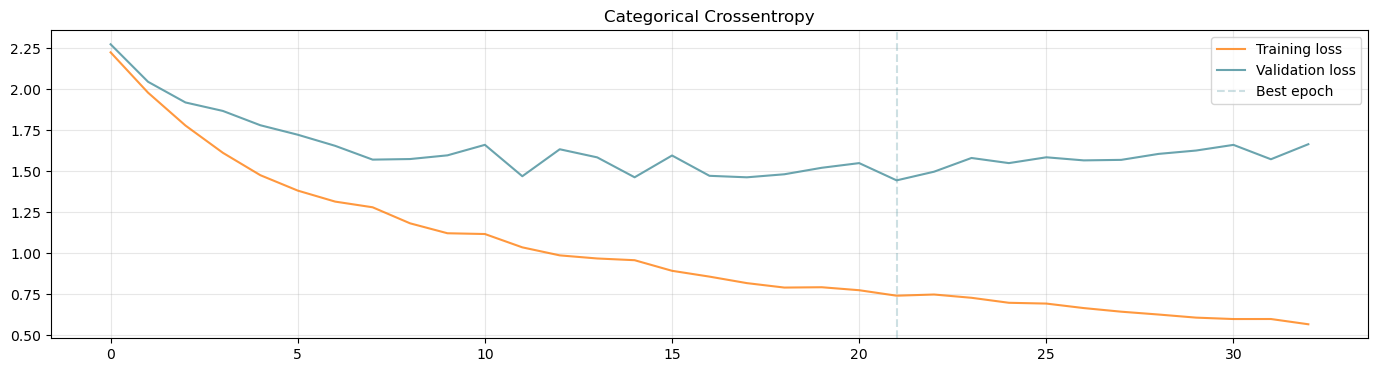

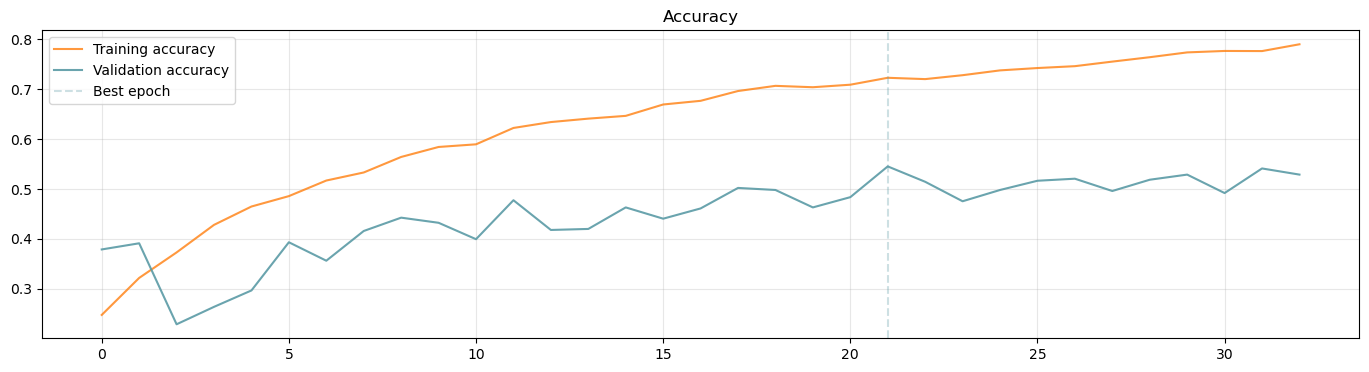

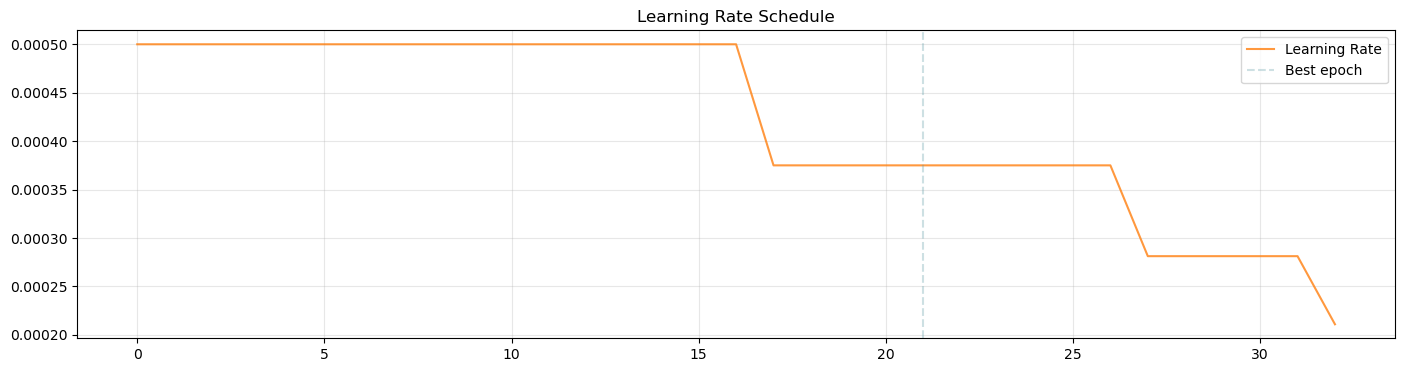

16/16 [==============================] - 0s 4ms/step
Accuracy: 0.5453
Precision: 0.5327
Recall: 0.5654
F1: 0.5227


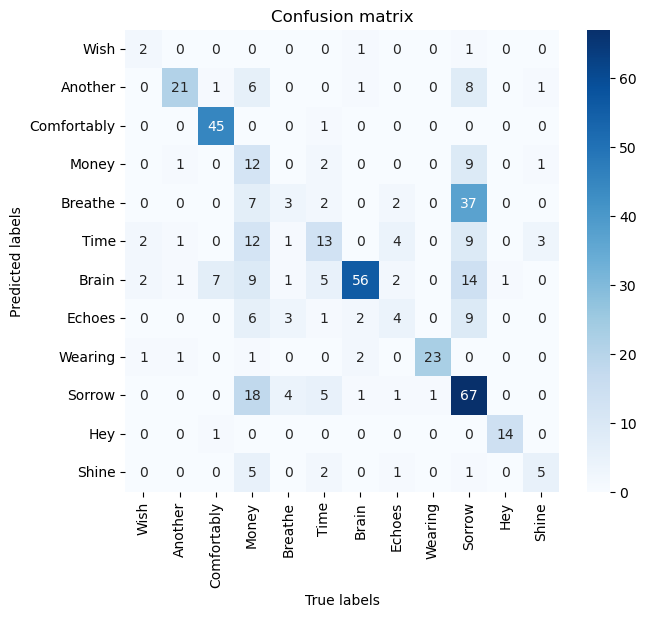

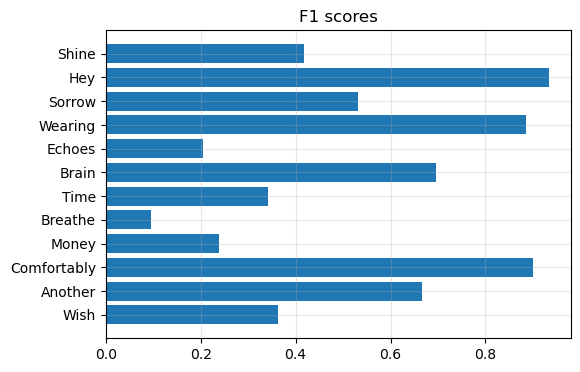

In [119]:
plot_history(history)

# Predict the test set with the LSTM
predictions = model.predict(X_test)

plot_statistics(predictions)

Save model with the validation accuracy in the name

In [120]:
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
if (accuracy > 0.71):
    model_name = "model_convdense_" + str(accuracy.round(5))
    model.save(model_name)
    
    shutil.make_archive(model_name, 'zip', model_name)
    FileLink(r"" + model_name + ".zip")

#### Bidirectional Long Short Term Memory (BiLSTM) Neural Network

In [121]:
def build_BiLSTM_classifier(input_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor

    x = tfkl.Conv1D(filters = 256, kernel_size = 3, padding = 'same',
        activation = 'relu', kernel_initializer = tfk.initializers.HeUniform(seed)
        )(input_layer)
    x = tfkl.MaxPooling1D()(x)
    x = tfkl.Conv1D(filters = 256, kernel_size = 3, padding = 'same',
        activation = 'relu', kernel_initializer = tfk.initializers.HeUniform(seed)
        )(x)
    x = tfkl.MaxPooling1D()(x)
    x = tfkl.Conv1D(filters = 256, kernel_size = 3, padding = 'same',
        activation = 'relu', kernel_initializer = tfk.initializers.HeUniform(seed)
        )(x)
    x = tfkl.MaxPooling1D()(x)

    x = tfkl.Dropout(.4, seed=seed)(x)

    bilstm = tfkl.Bidirectional(tfkl.LSTM(256, return_sequences=True))(x)
    bilstm = tfkl.Bidirectional(tfkl.LSTM(256, return_sequences=True))(bilstm)
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=False))(bilstm)

    x = tfkl.Dropout(.4, seed=seed)(bilstm)

    # Classifier
    x = tfkl.Dense(256, activation='relu')(x)
    x = tfkl.Dense(128, activation='relu')(x)
    x = tfkl.Dropout(.4, seed=seed)(x)
    output_layer = tfkl.Dense(classes, activation='softmax')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model2')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(3e-4), metrics='accuracy')

    # Return the model
    return model

In [122]:
model = build_BiLSTM_classifier(input_shape)
model.summary() #note double number of parameters (this is because we have a bidirectional lstm)

Model: "model2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 108, 6)]          0         
                                                                 
 conv1d_24 (Conv1D)          (None, 108, 256)          4864      
                                                                 
 max_pooling1d_14 (MaxPoolin  (None, 54, 256)          0         
 g1D)                                                            
                                                                 
 conv1d_25 (Conv1D)          (None, 54, 256)           196864    
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, 27, 256)          0         
 g1D)                                                            
                                                                 
 conv1d_26 (Conv1D)          (None, 27, 256)           19686

In [123]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_test, y_test),
    #class_weight = class_weights,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=11, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.75, min_lr=1e-5)
    ]
).history

Epoch 1/800
65/65 [==============================] - 22s 130ms/step - loss: 2.1600 - accuracy: 0.2409 - val_loss: 2.0490 - val_accuracy: 0.2058 - lr: 3.0000e-04
Epoch 2/800
65/65 [==============================] - 6s 85ms/step - loss: 1.7478 - accuracy: 0.3784 - val_loss: 1.8747 - val_accuracy: 0.3045 - lr: 3.0000e-04
Epoch 3/800
65/65 [==============================] - 6s 86ms/step - loss: 1.5591 - accuracy: 0.4332 - val_loss: 1.8104 - val_accuracy: 0.3086 - lr: 3.0000e-04
Epoch 4/800
65/65 [==============================] - 6s 87ms/step - loss: 1.4186 - accuracy: 0.4802 - val_loss: 1.7004 - val_accuracy: 0.3395 - lr: 3.0000e-04
Epoch 5/800
65/65 [==============================] - 6s 90ms/step - loss: 1.3025 - accuracy: 0.5261 - val_loss: 1.6294 - val_accuracy: 0.3128 - lr: 3.0000e-04
Epoch 6/800
65/65 [==============================] - 6s 92ms/step - loss: 1.1837 - accuracy: 0.5750 - val_loss: 1.6837 - val_accuracy: 0.3807 - lr: 3.0000e-04
Epoch 7/800
65/65 [=========================

Bidirectional LSTM model evaluation

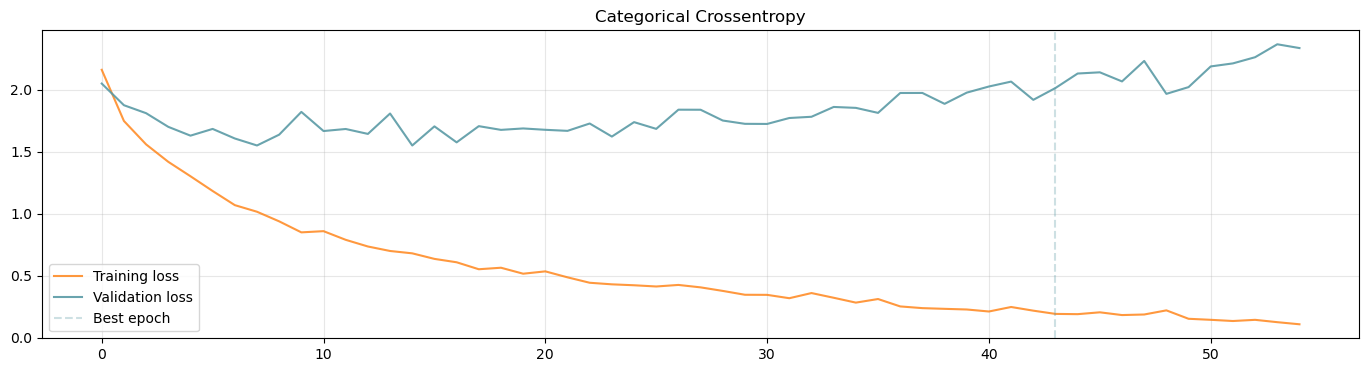

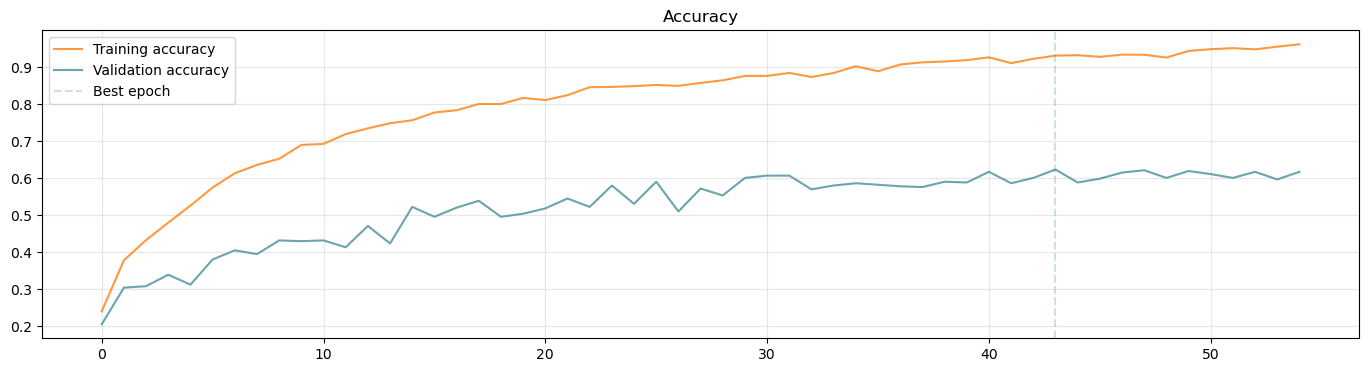

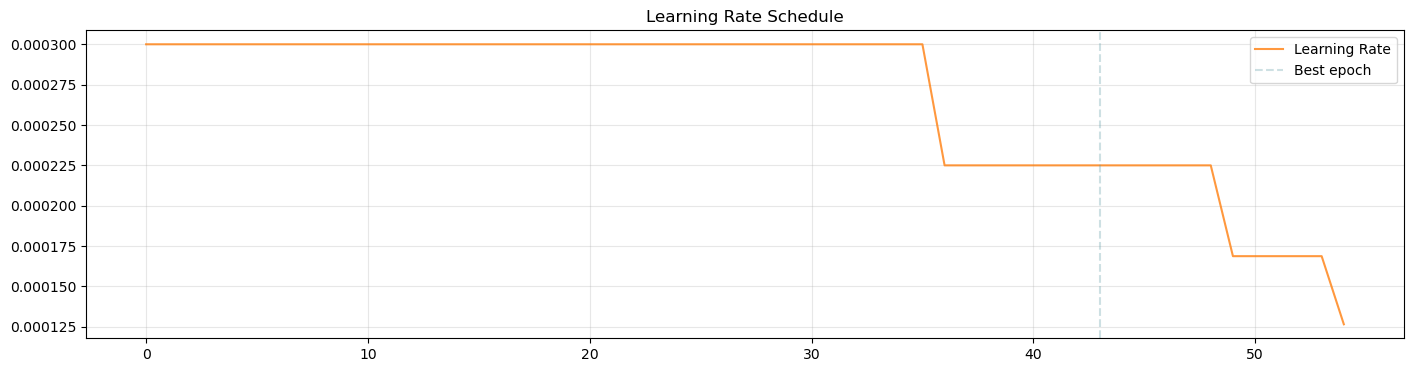

16/16 [==============================] - 3s 25ms/step
Accuracy: 0.6235
Precision: 0.5182
Recall: 0.5443
F1: 0.5258


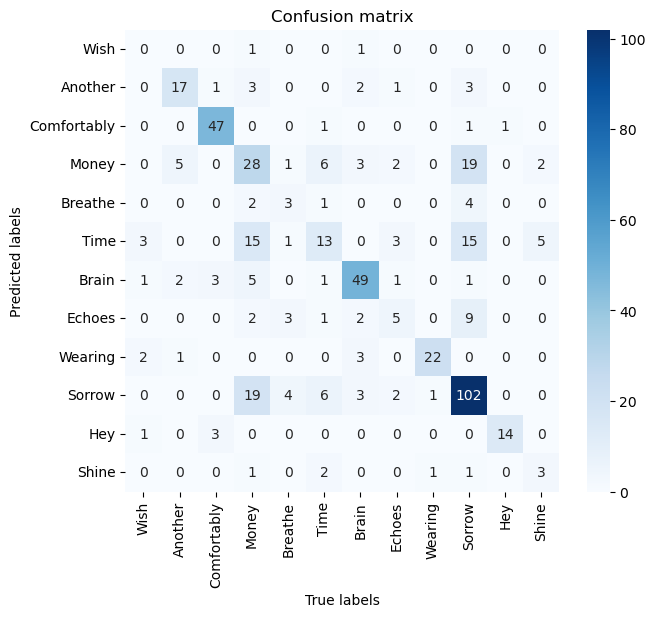

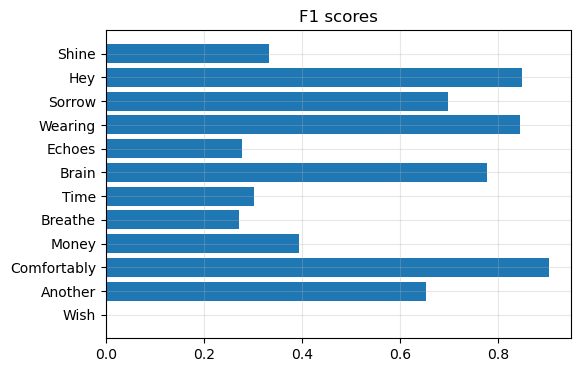

In [124]:
plot_history(history)

# Predict the test set with the LSTM
predictions = model.predict(X_test)

plot_statistics(predictions)

Save bidirectional lstm model with accuracy in the name

In [125]:
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
if (accuracy > 0.71):
    model_name = "model_bilstm_" + str(accuracy.round(5))
    model.save(model_name)
    
    shutil.make_archive(model_name, 'zip', model_name)
    FileLink(r"" + model_name + ".zip")